In [16]:
# Enhanced Face Clustering for Dating App - Experimental Version
# Import necessary libraries
import os
from PIL import Image, ImageEnhance
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import face_recognition
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, FactorAnalysis
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import shutil
from matplotlib.pyplot import imshow
import umap
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Path to the dataset
dataset_path = 'C:/Users/krexw/Documents/FREE_PROJECTS/DATING_APP/modeling/dataset/IndoDataset/Male'

# Create processed dataset directory
processed_dataset_path = os.path.join(os.path.dirname(dataset_path), 'Male_processed')
os.makedirs(processed_dataset_path, exist_ok=True)

def validate_and_preprocess_image(image_path, target_size=(512, 512), quality_threshold=50, 
                                 handle_small_images="upscale"):
    """
    Validate and preprocess images with standardization
    
    Args:
        image_path: Path to the image file
        target_size: Target size for output images
        quality_threshold: Minimum size threshold for images
        handle_small_images: How to handle small images
            - "skip": Skip small images (original behavior)
            - "upscale": Upscale small images using interpolation
            - "pad": Pad small images to meet threshold
            - "keep": Keep small images as-is but still process them
    """
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
                     
            width, height = img.size
            original_size = (width, height)
            
            # Handle small images based on the chosen strategy
            if width < quality_threshold or height < quality_threshold:
                print(f"Warning: {os.path.basename(image_path)} is small ({width}x{height})")
                
                if handle_small_images == "skip":
                    return None
                elif handle_small_images == "upscale":
                    # Calculate upscale factor to meet minimum threshold
                    scale_factor = max(quality_threshold / width, quality_threshold / height)
                    new_width = int(width * scale_factor * 1.1)  # Add 10% buffer
                    new_height = int(height * scale_factor * 1.1)
                    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                    print(f"  -> Upscaled to ({new_width}x{new_height})")
                elif handle_small_images == "pad":
                    # Pad the image to meet minimum size
                    pad_width = max(quality_threshold, width)
                    pad_height = max(quality_threshold, height)
                    padded_img = Image.new('RGB', (pad_width, pad_height), (128, 128, 128))  # Gray background
                    # Center the original image
                    x = (pad_width - width) // 2
                    y = (pad_height - height) // 2
                    padded_img.paste(img, (x, y))
                    img = padded_img
                    print(f"  -> Padded to ({pad_width}x{pad_height})")
                elif handle_small_images == "keep":
                    print(f"  -> Keeping original size")
                    pass  # Continue processing as-is
                     
            # Enhance image quality
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1.1)
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(1.1)
                     
            # Resize while maintaining aspect ratio
            img.thumbnail(target_size, Image.Resampling.LANCZOS)
                     
            # Center on white background
            processed_img = Image.new('RGB', target_size, (255, 255, 255))
            x = (target_size[0] - img.width) // 2
            y = (target_size[1] - img.height) // 2
            processed_img.paste(img, (x, y))
                     
            return processed_img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def filter_images_by_size(dataset_path, min_size=50):
    """
    Analyze image sizes in the dataset and provide statistics
    """
    image_files = [f for f in os.listdir(dataset_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    size_stats = {'too_small': [], 'acceptable': [], 'large': []}
    
    for img_file in image_files:
        img_path = os.path.join(dataset_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                min_dimension = min(width, height)
                
                if min_dimension < min_size:
                    size_stats['too_small'].append((img_file, width, height))
                elif min_dimension < 200:
                    size_stats['acceptable'].append((img_file, width, height))
                else:
                    size_stats['large'].append((img_file, width, height))
        except Exception as e:
            print(f"Error reading {img_file}: {e}")
    
    print(f"Image Size Analysis:")
    print(f"Too small (< {min_size}px): {len(size_stats['too_small'])} images")
    print(f"Acceptable ({min_size}-200px): {len(size_stats['acceptable'])} images")
    print(f"Large (> 200px): {len(size_stats['large'])} images")
    
    if size_stats['too_small']:
        print(f"\nSmallest images:")
        sorted_small = sorted(size_stats['too_small'], key=lambda x: min(x[1], x[2]))
        for img_file, w, h in sorted_small[:5]:
            print(f"  {img_file}: {w}x{h}")
    
    return size_stats

# Enhanced preprocessing with different strategies for small images
def preprocess_dataset_enhanced(original_dataset_path, processed_dataset_path, 
                              target_size=(512, 512), quality_threshold=50,
                              handle_small_images="upscale"):
    """
    Enhanced dataset preprocessing with multiple strategies for handling small images
    """
    os.makedirs(processed_dataset_path, exist_ok=True)
    
    original_image_files = [
        f for f in os.listdir(original_dataset_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    print(f"Found {len(original_image_files)} images in the original dataset")
    
    # First, analyze the dataset
    print("\nAnalyzing image sizes...")
    size_stats = filter_images_by_size(original_dataset_path, quality_threshold)
    
    # Preprocess images
    if not os.listdir(processed_dataset_path):
        print(f"\nPreprocessing images with strategy: {handle_small_images}")
        valid_count = 0
        skipped_count = 0
        
        for img_file in tqdm(original_image_files):
            img_path = os.path.join(original_dataset_path, img_file)
            processed_img = validate_and_preprocess_image(
                img_path, target_size, quality_threshold, handle_small_images
            )
                     
            if processed_img is not None:
                base_name = os.path.splitext(img_file)[0]
                output_path = os.path.join(processed_dataset_path, f"{base_name}.jpg")
                processed_img.save(output_path, 'JPEG', quality=95, optimize=True)
                valid_count += 1
            else:
                skipped_count += 1
                 
        print(f"Processed: {valid_count}/{len(original_image_files)} images")
        if skipped_count > 0:
            print(f"Skipped: {skipped_count} images")
    else:
        print("Using existing preprocessed images")
    
    return processed_dataset_path

# Usage example with different strategies:

# Strategy 1: Upscale small images (Recommended)
print("=== STRATEGY 1: UPSCALE SMALL IMAGES ===")
processed_dataset_path_upscale = os.path.join(os.path.dirname(dataset_path), 'Male_processed_upscale')
preprocess_dataset_enhanced(
    original_dataset_path=dataset_path,  # Your original dataset path
    processed_dataset_path=processed_dataset_path_upscale,
    handle_small_images="upscale"
)

# Strategy 2: Pad small images
print("\n=== STRATEGY 2: PAD SMALL IMAGES ===")
processed_dataset_path_pad = os.path.join(os.path.dirname(dataset_path), 'Male_processed_pad')
preprocess_dataset_enhanced(
    original_dataset_path=dataset_path,  # Your original dataset path
    processed_dataset_path=processed_dataset_path_pad,
    handle_small_images="pad"
)

# Strategy 3: Keep all images regardless of size
print("\n=== STRATEGY 3: KEEP ALL IMAGES ===")
processed_dataset_path_keep = os.path.join(os.path.dirname(dataset_path), 'Male_processed_keep')
preprocess_dataset_enhanced(
    original_dataset_path=dataset_path,  # Your original dataset path
    processed_dataset_path=processed_dataset_path_keep,
    handle_small_images="keep"
)

# Strategy 4: Lower the quality threshold
print("\n=== STRATEGY 4: LOWER QUALITY THRESHOLD ===")
processed_dataset_path_lower = os.path.join(os.path.dirname(dataset_path), 'Male_processed_lower')
preprocess_dataset_enhanced(
    original_dataset_path=dataset_path,  # Your original dataset path
    processed_dataset_path=processed_dataset_path_lower,
    quality_threshold=20,  # Much lower threshold
    handle_small_images="upscale"
)

# Choose which processed dataset to use for face recognition
# Recommendation: Use the upscaled version for best results
final_dataset_path = processed_dataset_path_upscale
image_files = [f for f in os.listdir(final_dataset_path) if f.endswith('.jpg')]
image_files.sort()

print(f"\nUsing final dataset: {final_dataset_path}")
print(f"Final image count: {len(image_files)}")

=== STRATEGY 1: UPSCALE SMALL IMAGES ===
Found 581 images in the original dataset

Analyzing image sizes...
Image Size Analysis:
Too small (< 50px): 152 images
Acceptable (50-200px): 200 images
Large (> 200px): 229 images

Smallest images:
  13020220309_tr_13020220309 (202).png: 21x167
  13020220328_tr_13020220328 (116).png: 24x364
  13020220332_tr_13020220332 (115).png: 30x321
  Andovi_Da_Lopez_12.jpg: 33x33
  Basuki_Tjahaja_Purnama_2.jpg: 33x33

Preprocessing images with strategy: upscale


  0%|          | 0/581 [00:00<?, ?it/s]

  -> Upscaled to (55x437)
  -> Upscaled to (55x834)
  -> Upscaled to (55x588)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x55)
  -> Upscaled to (55x5

  0%|          | 0/581 [00:00<?, ?it/s]

  -> Padded to (50x167)
  -> Padded to (50x364)
  -> Padded to (50x321)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Padded to (50x50)
  -> Pad

  0%|          | 0/581 [00:00<?, ?it/s]

  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
  -> Keeping original size
 

  0%|          | 0/581 [00:00<?, ?it/s]

Processed: 581/581 images

Using final dataset: C:/Users/krexw/Documents/FREE_PROJECTS/DATING_APP/modeling/dataset/IndoDataset\Male_processed_upscale
Final image count: 581


In [39]:
import os
import numpy as np
import cv2
import face_recognition
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding, Isomap
import warnings
from pathlib import Path  # Better path handling
warnings.filterwarnings('ignore')

try:
    import umap
except ImportError:
    print("UMAP not installed. Install with: pip install umap-learn")
    umap = None

def normalize_path(path):
    """Normalize path separators for cross-platform compatibility"""
    return str(Path(path).resolve())

def extract_face_encodings_enhanced(image_path, model="hog", num_jitters=1, tolerance=0.6):
    """Enhanced face encoding extraction with multiple detection methods and better error handling"""
    try:
        # Normalize the path first
        image_path = normalize_path(image_path)
        
        # Check if file exists before processing
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            return [], []
        
        # Load image
        image = face_recognition.load_image_file(image_path)
        
        # Try different face detection models with different parameters
        face_locations = face_recognition.face_locations(image, model=model, number_of_times_to_upsample=1)
        
        # Fallback strategies if no faces found
        if not face_locations and model == "hog":
            # Try CNN model
            face_locations = face_recognition.face_locations(image, model="cnn", number_of_times_to_upsample=1)
        
        if not face_locations:
            # Try with more upsampling
            face_locations = face_recognition.face_locations(image, model="hog", number_of_times_to_upsample=2)
        
        if not face_locations:
            # Last resort: try with different tolerance
            face_locations = face_recognition.face_locations(image, model="cnn", number_of_times_to_upsample=2)
        
        # Get face encodings with jittering for better accuracy
        face_encodings = []
        if face_locations:
            face_encodings = face_recognition.face_encodings(
                image, 
                face_locations, 
                num_jitters=num_jitters,
                model="large"  # Use large model for better accuracy
            )
        
        return face_locations, face_encodings
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return [], []

def extract_additional_features(image_path, debug=False):
    """Extract additional facial features beyond face_recognition encodings"""
    try:
        # Normalize the path first
        image_path = normalize_path(image_path)
        
        # Check if file exists
        if not os.path.exists(image_path):
            if debug:
                print(f"File not found: {image_path}")
            return np.array([])
        
        # Load image with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            if debug:
                print(f"Could not load image: {image_path}")
            return np.array([])
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Multiple face detection methods for robustness
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(30, 30))
        
        # Try alternative cascade if no faces found
        if len(faces) == 0:
            face_cascade_alt = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
            faces = face_cascade_alt.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))
        
        additional_features = []
        
        if len(faces) > 0:
            # Take the largest face
            face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = face
            
            # Extract face region with some padding
            padding = 10
            y1 = max(0, y - padding)
            y2 = min(gray.shape[0], y + h + padding)
            x1 = max(0, x - padding)
            x2 = min(gray.shape[1], x + w + padding)
            
            face_roi = gray[y1:y2, x1:x2]
            
            if face_roi.size > 0:
                # Geometric features
                aspect_ratio = w / h
                face_area = w * h
                face_center_x = x + w/2
                face_center_y = y + h/2
                
                # Normalize by image dimensions
                img_height, img_width = gray.shape
                normalized_center_x = face_center_x / img_width
                normalized_center_y = face_center_y / img_height
                normalized_area = face_area / (img_width * img_height)
                
                # Resize face for consistent feature extraction
                face_resized = cv2.resize(face_roi, (64, 64))
                
                # Histogram features (multiple bins)
                hist = cv2.calcHist([face_resized], [0], None, [16], [0, 256])
                hist = hist.flatten() / (np.sum(hist) + 1e-7)  # Normalize with small epsilon
                
                # Gradient features
                grad_x = cv2.Sobel(face_resized, cv2.CV_64F, 1, 0, ksize=3)
                grad_y = cv2.Sobel(face_resized, cv2.CV_64F, 0, 1, ksize=3)
                gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
                
                # Statistical features from gradients
                grad_mean = np.mean(gradient_magnitude)
                grad_std = np.std(gradient_magnitude)
                grad_max = np.max(gradient_magnitude)
                grad_min = np.min(gradient_magnitude)
                
                # Edge density
                edges = cv2.Canny(face_resized, 50, 150)
                edge_density = np.sum(edges > 0) / edges.size
                
                # Combine all features (simplified to avoid LBP complexity)
                additional_features = [
                    aspect_ratio, normalized_area, normalized_center_x, normalized_center_y,
                    grad_mean, grad_std, grad_max, grad_min, edge_density
                ] + hist.tolist()
                
        return np.array(additional_features) if additional_features else np.array([])
        
    except Exception as e:
        if debug:
            print(f"Error extracting additional features from {image_path}: {e}")
        return np.array([])

def get_valid_image_files(dataset_path):
    """Get list of valid image files with proper path handling"""
    dataset_path = normalize_path(dataset_path)
    
    if not os.path.exists(dataset_path):
        print(f"Dataset path does not exist: {dataset_path}")
        return []
    
    valid_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'}
    image_files = []
    
    print(f"Scanning directory: {dataset_path}")
    
    for filename in os.listdir(dataset_path):
        file_extension = Path(filename).suffix.lower()
        if file_extension in valid_extensions:
            full_path = os.path.join(dataset_path, filename)
            if os.path.exists(full_path):
                image_files.append(filename)
            else:
                print(f"Warning: File listed but not accessible: {full_path}")
    
    image_files.sort()
    print(f"Found {len(image_files)} valid image files")
    
    # Show first few files for verification
    if image_files:
        print("First few files:")
        for i, img in enumerate(image_files[:5]):
            full_path = os.path.join(dataset_path, img)
            exists = "✓" if os.path.exists(full_path) else "✗"
            print(f"  {exists} {img}")
        if len(image_files) > 5:
            print(f"  ... and {len(image_files) - 5} more")
    
    return image_files

def process_face_features_robust(image_files, dataset_path, save_progress=True, progress_file="face_features_progress.pkl"):
    """
    Robust face feature extraction with progress saving and error handling
    """
    # Normalize dataset path
    dataset_path = normalize_path(dataset_path)
    
    # Try to load existing progress
    all_encodings = []
    all_locations = []
    all_additional_features = []
    image_paths = []
    face_indices = []
    processed_files = set()
    
    if save_progress and os.path.exists(progress_file):
        try:
            with open(progress_file, 'rb') as f:
                progress_data = pickle.load(f)
                all_encodings = progress_data.get('encodings', [])
                all_locations = progress_data.get('locations', [])
                all_additional_features = progress_data.get('additional_features', [])
                image_paths = progress_data.get('image_paths', [])
                face_indices = progress_data.get('face_indices', [])
                processed_files = progress_data.get('processed_files', set())
                print(f"Resumed from progress: {len(processed_files)} files already processed")
        except Exception as e:
            print(f"Could not load progress file: {e}")
            print("Starting fresh...")
    
    print("Extracting face encodings and additional features...")
    
    # Track statistics
    stats = {
        'total_files': len(image_files),
        'files_with_faces': 0,
        'total_faces_found': 0,
        'files_no_faces': 0,
        'processing_errors': 0,
        'file_not_found_errors': 0
    }
    
    for i, img_file in enumerate(tqdm(image_files, desc="Processing images")):
        if img_file in processed_files:
            continue
        
        # Use proper path joining
        img_path = normalize_path(os.path.join(dataset_path, img_file))
        
        # Double-check file existence
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            stats['file_not_found_errors'] += 1
            processed_files.add(img_file)  # Mark as processed to avoid retry
            continue
        
        try:
            # Extract face encodings
            face_locations, face_encodings = extract_face_encodings_enhanced(img_path)
            
            # Extract additional features
            additional_features = extract_additional_features(img_path)
            
            if len(face_encodings) > 0:
                stats['files_with_faces'] += 1
                stats['total_faces_found'] += len(face_encodings)
                
                for j, encoding in enumerate(face_encodings):
                    all_encodings.append(encoding)
                    all_locations.append(face_locations[j])
                    all_additional_features.append(additional_features)
                    image_paths.append(img_path)
                    face_indices.append(i)
            else:
                stats['files_no_faces'] += 1
            
            processed_files.add(img_file)
            
            # Save progress every 50 files (more frequent saves)
            if save_progress and (len(processed_files) % 50 == 0):
                progress_data = {
                    'encodings': all_encodings,
                    'locations': all_locations,
                    'additional_features': all_additional_features,
                    'image_paths': image_paths,
                    'face_indices': face_indices,
                    'processed_files': processed_files
                }
                with open(progress_file, 'wb') as f:
                    pickle.dump(progress_data, f)
                print(f"Progress saved: {len(processed_files)} files processed")
        
        except Exception as e:
            stats['processing_errors'] += 1
            print(f"Error processing {img_file}: {e}")
            processed_files.add(img_file)  # Mark as processed to avoid infinite retry
            continue
    
    # Final save
    if save_progress:
        progress_data = {
            'encodings': all_encodings,
            'locations': all_locations,
            'additional_features': all_additional_features,
            'image_paths': image_paths,
            'face_indices': face_indices,
            'processed_files': processed_files
        }
        with open(progress_file, 'wb') as f:
            pickle.dump(progress_data, f)
    
    # Print statistics
    print(f"\n=== PROCESSING STATISTICS ===")
    print(f"Total files processed: {stats['total_files']}")
    print(f"Files with faces: {stats['files_with_faces']} ({stats['files_with_faces']/max(stats['total_files'],1)*100:.1f}%)")
    print(f"Files without faces: {stats['files_no_faces']} ({stats['files_no_faces']/max(stats['total_files'],1)*100:.1f}%)")
    print(f"Total faces found: {stats['total_faces_found']}")
    print(f"Average faces per image: {stats['total_faces_found']/max(stats['files_with_faces'], 1):.2f}")
    print(f"Processing errors: {stats['processing_errors']}")
    print(f"File not found errors: {stats['file_not_found_errors']}")
    print(f"Final feature count: {len(all_encodings)} faces")
    
    return all_encodings, all_locations, all_additional_features, image_paths, face_indices, stats

def prepare_combined_features(all_encodings, all_additional_features):
    """Prepare combined features from face encodings and additional features"""
    if len(all_encodings) == 0:
        return np.array([])
    
    # Convert face encodings to numpy array
    face_encodings_array = np.array(all_encodings)
    print(f"Face encodings shape: {face_encodings_array.shape}")
    
    # Handle additional features
    if all_additional_features and len(all_additional_features) > 0:
        # Filter out empty additional features
        valid_additional = [feat for feat in all_additional_features if len(feat) > 0]
        
        if valid_additional:
            # Find the maximum length of additional features
            max_len = max(len(feat) for feat in valid_additional)
            print(f"Max additional feature length: {max_len}")
            
            # Pad or truncate all additional features to the same length
            padded_additional = []
            for i, feat in enumerate(all_additional_features):
                if len(feat) == 0:
                    # If no additional features extracted, fill with zeros
                    padded_additional.append(np.zeros(max_len))
                elif len(feat) < max_len:
                    # Pad with zeros if too short
                    padded = np.pad(feat, (0, max_len - len(feat)), 'constant', constant_values=0)
                    padded_additional.append(padded)
                else:
                    # Truncate if too long
                    padded_additional.append(feat[:max_len])
            
            additional_features_array = np.array(padded_additional)
            print(f"Additional features shape: {additional_features_array.shape}")
            
            # Check if shapes are compatible
            if face_encodings_array.shape[0] == additional_features_array.shape[0]:
                # Combine face encodings with additional features
                combined_features = np.hstack([face_encodings_array, additional_features_array])
                print(f"Combined features with additional features: {combined_features.shape}")
            else:
                print("Shape mismatch between face encodings and additional features. Using only face encodings.")
                combined_features = face_encodings_array
        else:
            print("No valid additional features found. Using only face encodings.")
            combined_features = face_encodings_array
    else:
        print("No additional features provided. Using only face encodings.")
        combined_features = face_encodings_array
    
    return combined_features

# Usage example with proper path handling:
if __name__ == "__main__":
    # Set your dataset path here
    dataset_path = r'C:\Users\krexw\Documents\FREE_PROJECTS\DATING_APP\modeling\dataset\IndoDataset\Male_processed_upscale'
    
    # Get valid image files with proper path handling
    image_files = get_valid_image_files(dataset_path)
    
    if not image_files:
        print("No valid image files found!")
        combined_features = np.array([])
    else:
        # Process face features with robust error handling
        all_encodings, all_locations, all_additional_features, image_paths, face_indices, stats = process_face_features_robust(
            image_files, dataset_path, save_progress=True
        )
        
        if len(all_encodings) > 0:
            print(f"\n✓ Successfully extracted features from {len(all_encodings)} faces")
            
            # Prepare combined features for dimensionality reduction
            combined_features = prepare_combined_features(all_encodings, all_additional_features)
        else:
            print("\n✗ No face features were extracted. Check your images and paths.")
            combined_features = np.array([])

Scanning directory: C:\Users\krexw\Documents\FREE_PROJECTS\DATING_APP\modeling\dataset\IndoDataset\Male_processed_upscale
Found 581 valid image files
First few files:
  ✓ 13020220048_tr_13020220048 (103).jpg
  ✓ 13020220048_tr_13020220048 (2).jpg
  ✓ 13020220048_tr_13020220048 (47).jpg
  ✓ 13020220048_tr_13020220048 (63).jpg
  ✓ 13020220048_tr_13020220048 (92).jpg
  ... and 576 more
Resumed from progress: 816 files already processed
Extracting face encodings and additional features...


Processing images: 100%|██████████| 581/581 [00:00<00:00, 583267.26it/s]


=== PROCESSING STATISTICS ===
Total files processed: 581
Files with faces: 0 (0.0%)
Files without faces: 0 (0.0%)
Total faces found: 0
Average faces per image: 0.00
Processing errors: 0
File not found errors: 0
Final feature count: 572 faces

✓ Successfully extracted features from 572 faces
Face encodings shape: (572, 128)
Max additional feature length: 41
Additional features shape: (572, 41)
Combined features with additional features: (572, 169)


In [40]:
def experiment_dimensionality_reduction(features, n_components_list=[2, 5, 10, 20, 50]):
    """Experiment with various dimensionality reduction techniques"""
    
    results = {}
    
    if len(features) == 0:
        print("No features to process!")
        return results, None
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    print("=== DIMENSIONALITY REDUCTION EXPERIMENTS ===")
    print(f"Original feature dimensions: {features.shape[1]}")
    print()
    
    # Define reduction methods with extreme parameters
    reduction_methods = {
        'PCA': lambda n: PCA(n_components=n, random_state=42),
        'FastICA': lambda n: FastICA(n_components=n, random_state=42, max_iter=1000),
        'TruncatedSVD': lambda n: TruncatedSVD(n_components=n, random_state=42),
        'Random_Projection_Gaussian': lambda n: GaussianRandomProjection(n_components=n, random_state=42),
        'Random_Projection_Sparse': lambda n: SparseRandomProjection(n_components=n, random_state=42),
        'Factor_Analysis': lambda n: FactorAnalysis(n_components=n, random_state=42),
    }
    
    # Add UMAP methods if available
    if umap is not None:
        reduction_methods.update({
            'UMAP_Conservative': lambda n: umap.UMAP(n_components=n, n_neighbors=15, min_dist=0.1, random_state=42),
            'UMAP_Aggressive': lambda n: umap.UMAP(n_components=n, n_neighbors=5, min_dist=0.01, random_state=42),
            'UMAP_Extreme': lambda n: umap.UMAP(n_components=n, n_neighbors=3, min_dist=0.001, random_state=42),
        })
    
    # Add non-linear methods for smaller dimensions only
    nonlinear_methods = {
        'TSNE_Conservative': lambda n: TSNE(n_components=min(n, 3), perplexity=30, random_state=42),
        'TSNE_Extreme': lambda n: TSNE(n_components=min(n, 3), perplexity=5, learning_rate=1000, random_state=42),
        'MDS': lambda n: MDS(n_components=min(n, 10), random_state=42),
        'Locally_Linear_Embedding': lambda n: LocallyLinearEmbedding(n_components=min(n, 10), random_state=42),
        'Isomap': lambda n: Isomap(n_components=min(n, 10)),
    }
    
    for method_name, method_func in reduction_methods.items():
        print(f"\n--- {method_name} ---")
        method_results = {}
        
        for n_comp in n_components_list:
            if n_comp >= features.shape[1]:
                continue
                
            try:
                reducer = method_func(n_comp)
                reduced_features = reducer.fit_transform(scaled_features)
                
                # Calculate explained variance if available
                explained_var = None
                if hasattr(reducer, 'explained_variance_ratio_'):
                    explained_var = np.sum(reducer.explained_variance_ratio_)
                elif hasattr(reducer, 'components_'):
                    # For methods like FastICA, calculate reconstruction error as proxy
                    try:
                        reconstructed = reducer.inverse_transform(reduced_features)
                        mse = np.mean((scaled_features - reconstructed)**2)
                        explained_var = 1 - mse / np.var(scaled_features)
                    except:
                        explained_var = None
                
                # Calculate feature variance
                feature_variance = np.var(reduced_features, axis=0)
                total_variance = np.sum(feature_variance)
                max_variance = np.max(feature_variance)
                variance_ratio = max_variance / total_variance if total_variance > 0 else 0
                
                method_results[n_comp] = {
                    'reduced_features': reduced_features,
                    'explained_variance': explained_var,
                    'total_variance': total_variance,  
                    'max_variance': max_variance,
                    'variance_ratio': variance_ratio,
                    'feature_variances': feature_variance
                }
                
                print(f"  {n_comp} components: Variance={total_variance:.4f}, Max Var Ratio={variance_ratio:.4f}", end="")
                if explained_var is not None:
                    print(f", Explained Var={explained_var:.4f}")
                else:
                    print()
                    
            except Exception as e:
                print(f"  {n_comp} components: Failed - {e}")
        
        results[method_name] = method_results
    
    # Non-linear methods (for smaller dimensions)
    small_n_components = [n for n in n_components_list if n <= 10]
    
    for method_name, method_func in nonlinear_methods.items():
        print(f"\n--- {method_name} (Non-linear) ---")
        method_results = {}
        
        for n_comp in small_n_components:
            if n_comp >= features.shape[1]:
                continue
                
            try:
                reducer = method_func(n_comp)
                reduced_features = reducer.fit_transform(scaled_features)
                
                # Calculate feature variance
                feature_variance = np.var(reduced_features, axis=0)
                total_variance = np.sum(feature_variance)
                max_variance = np.max(feature_variance)
                variance_ratio = max_variance / total_variance if total_variance > 0 else 0
                
                method_results[n_comp] = {
                    'reduced_features': reduced_features,
                    'explained_variance': None,
                    'total_variance': total_variance,
                    'max_variance': max_variance,
                    'variance_ratio': variance_ratio,
                    'feature_variances': feature_variance
                }
                
                print(f"  {n_comp} components: Variance={total_variance:.4f}, Max Var Ratio={variance_ratio:.4f}")
                    
            except Exception as e:
                print(f"  {n_comp} components: Failed - {e}")
        
        results[method_name] = method_results
    
    return results, scaler

# Run dimensionality reduction experiments
if len(combined_features) > 0:
    dr_results, feature_scaler = experiment_dimensionality_reduction(combined_features)
    print(f"\n✓ Dimensionality reduction completed on {len(combined_features)} samples")
else:
    dr_results, feature_scaler = {}, None
    print("\n✗ No features available for dimensionality reduction")

=== DIMENSIONALITY REDUCTION EXPERIMENTS ===
Original feature dimensions: 169


--- PCA ---
  2 components: Variance=34.2289, Max Var Ratio=0.5985, Explained Var=0.2037
  5 components: Variance=58.9052, Max Var Ratio=0.3478, Explained Var=0.3506
  10 components: Variance=82.6839, Max Var Ratio=0.2478, Explained Var=0.4922
  20 components: Variance=113.1938, Max Var Ratio=0.1810, Explained Var=0.6738
  50 components: Variance=151.8591, Max Var Ratio=0.1349, Explained Var=0.9039

--- FastICA ---
  2 components: Variance=2.0000, Max Var Ratio=0.5000, Explained Var=0.2037
  5 components: Variance=5.0000, Max Var Ratio=0.2000, Explained Var=0.3506
  10 components: Variance=10.0000, Max Var Ratio=0.1000, Explained Var=0.4922
  20 components: Variance=20.0000, Max Var Ratio=0.0500, Explained Var=0.6740
  50 components: Variance=50.0000, Max Var Ratio=0.0200, Explained Var=0.9042

--- TruncatedSVD ---
  2 components: Variance=34.2289, Max Var Ratio=0.5985, Explained Var=0.2037
  5 components: 

In [41]:
def evaluate_clustering_comprehensive(features, labels):
    """Comprehensive clustering evaluation with multiple metrics"""
    
    # Remove noise points for silhouette score
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) < 2:
        return {
            'silhouette_score': np.nan,
            'calinski_harabasz_score': np.nan,
            'davies_bouldin_score': np.nan,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
            'n_noise': np.sum(labels == -1),
            'cluster_sizes': {}
        }
    
    clean_features = features[non_noise_mask]
    clean_labels = labels[non_noise_mask]
    
    # Calculate metrics
    silhouette = silhouette_score(clean_features, clean_labels) if len(set(clean_labels)) > 1 else np.nan
    calinski = calinski_harabasz_score(clean_features, clean_labels) if len(set(clean_labels)) > 1 else np.nan
    davies_bouldin = davies_bouldin_score(clean_features, clean_labels) if len(set(clean_labels)) > 1 else np.nan
    
    # Cluster analysis
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    
    return {
        'silhouette_score': silhouette,
        'calinski_harabasz_score': calinski,
        'davies_bouldin_score': davies_bouldin,
        'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
        'n_noise': np.sum(labels == -1),
        'cluster_sizes': cluster_sizes
    }

def experiment_clustering_methods(features, method_name="Unknown"):
    """Experiment with different clustering methods and parameters"""
    
    print(f"\n=== CLUSTERING EXPERIMENTS: {method_name} ===")
    print(f"Feature shape: {features.shape}")
    
    clustering_results = []
    
    # K-Means experiments
    print("\n--- K-Means Clustering ---")
    k_values = [5, 10, 15, 20, 25, 30, 40, 50]
    
    for k in k_values:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(features)
            
            metrics = evaluate_clustering_comprehensive(features, labels)
            metrics['method'] = 'K-Means'
            metrics['parameters'] = {'k': k}
            
            clustering_results.append(metrics)
            
            print(f"  K={k:2d}: Silhouette={metrics['silhouette_score']:.4f}, " +
                  f"Calinski-Harabasz={metrics['calinski_harabasz_score']:.2f}, " +
                  f"Davies-Bouldin={metrics['davies_bouldin_score']:.4f}")
            
        except Exception as e:
            print(f"  K={k}: Failed - {e}")
    
    # DBSCAN experiments
    print("\n--- DBSCAN Clustering ---")
    eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
    min_samples_values = [3, 5, 10, 15]
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(features)
                
                metrics = evaluate_clustering_comprehensive(features, labels)
                metrics['method'] = 'DBSCAN'
                metrics['parameters'] = {'eps': eps, 'min_samples': min_samples}
                
                clustering_results.append(metrics)
                
                if metrics['n_clusters'] > 1:
                    print(f"  eps={eps:.1f}, min_samples={min_samples:2d}: " +
                          f"Clusters={metrics['n_clusters']:2d}, Noise={metrics['n_noise']:3d}, " +
                          f"Silhouette={metrics['silhouette_score']:.4f}")
                    
            except Exception as e:
                continue
    
    return clustering_results


COMPREHENSIVE CLUSTERING ANALYSIS
✓ All required variables found

🔍 EXPERIMENT 1: Original Face Encodings Only
   Feature shape: (346, 128)

=== CLUSTERING EXPERIMENTS: Face Encodings Only ===
Feature shape: (346, 128)

--- K-Means Clustering ---
  K= 5: Silhouette=0.0579, Calinski-Harabasz=17.30, Davies-Bouldin=2.8825
  K=10: Silhouette=0.0573, Calinski-Harabasz=12.88, Davies-Bouldin=2.6849
  K=15: Silhouette=0.0773, Calinski-Harabasz=10.82, Davies-Bouldin=2.5716
  K=20: Silhouette=0.0820, Calinski-Harabasz=9.67, Davies-Bouldin=2.4254
  K=25: Silhouette=0.0889, Calinski-Harabasz=8.86, Davies-Bouldin=2.2381
  K=30: Silhouette=0.0987, Calinski-Harabasz=8.40, Davies-Bouldin=2.1543
  K=40: Silhouette=0.1172, Calinski-Harabasz=7.76, Davies-Bouldin=1.9916
  K=50: Silhouette=0.1162, Calinski-Harabasz=7.14, Davies-Bouldin=1.8163

--- DBSCAN Clustering ---
  eps=0.3, min_samples= 3: Clusters= 2, Noise=337, Silhouette=0.5797
  eps=0.5, min_samples= 3: Clusters= 6, Noise= 23, Silhouette=0.0314


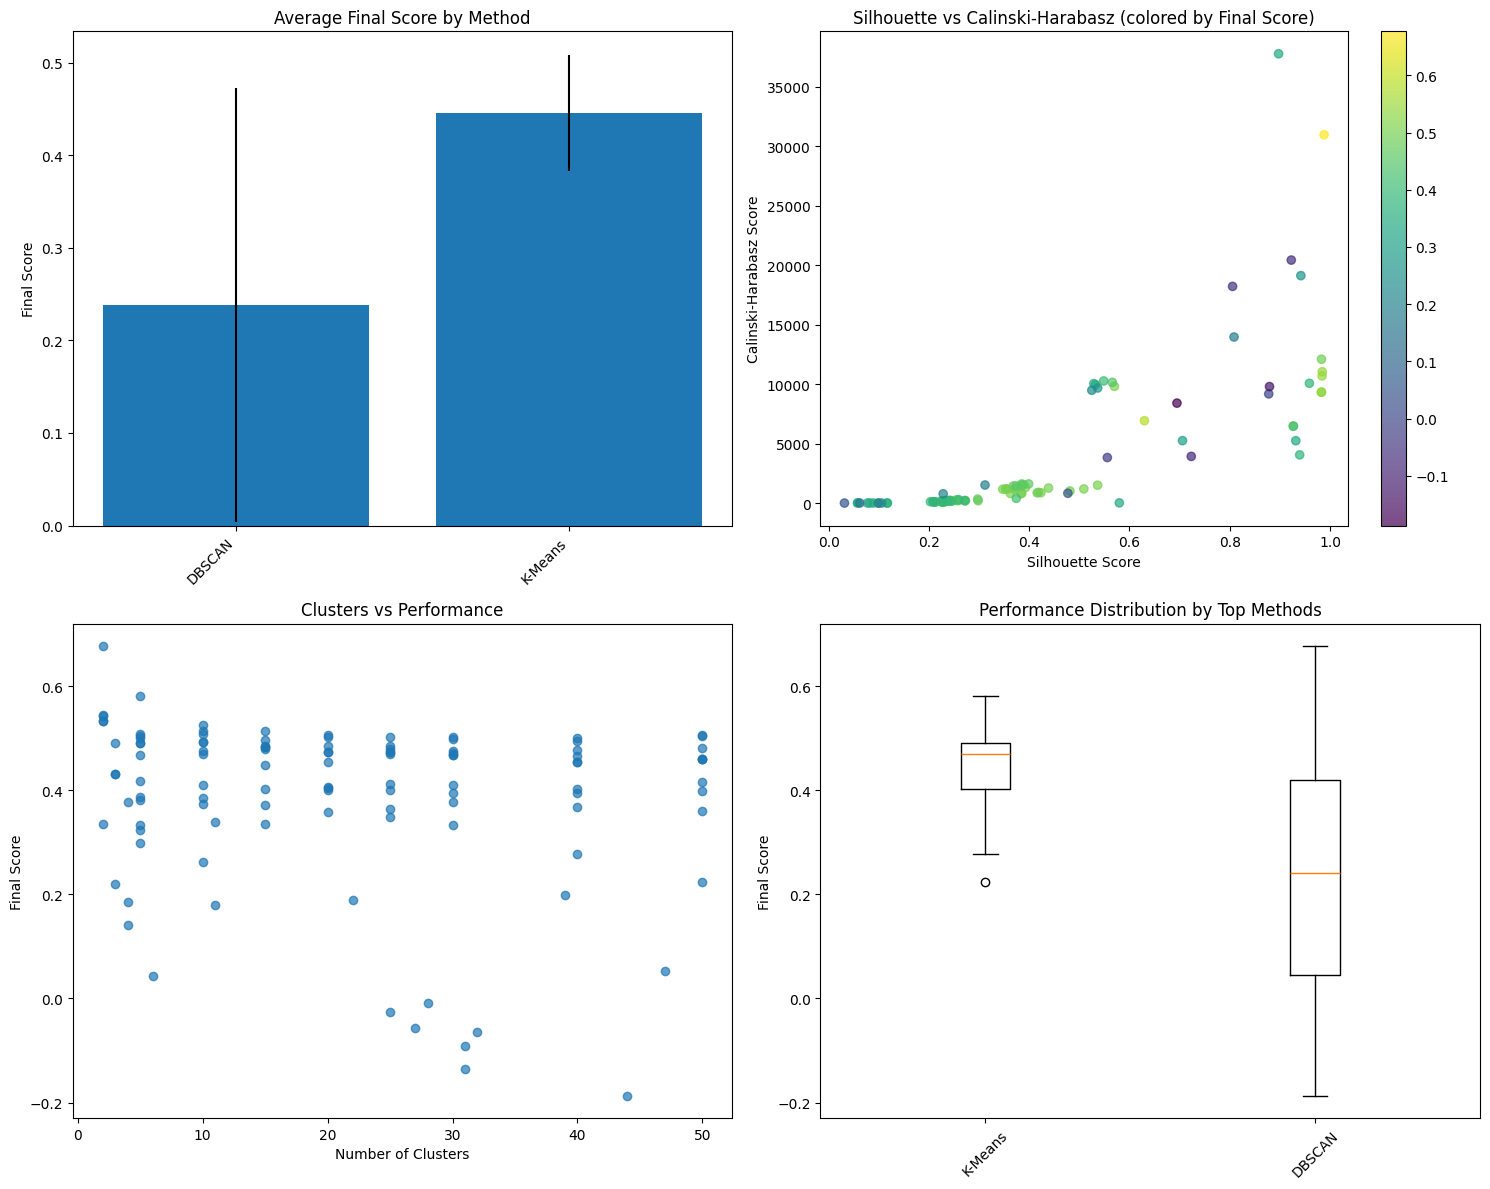


🎯 RECOMMENDED CLUSTERING CONFIGURATION:
   Method: DBSCAN
   Parameters: eps=0.7, min_samples=5
   Dimensionality Reduction: Isomap (2 components)
   Final Score: 0.6768
   Expected Clusters: 2

💡 Use 'BEST_CLUSTERING_CONFIG' variable in next cells for implementation

✅ Analysis complete! Check the results above and saved file for detailed metrics.


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import numpy as np

def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        # Convert both keys and values, handling numpy types in keys
        new_dict = {}
        for key, value in obj.items():
            # Convert numpy keys to native Python types
            if isinstance(key, (np.integer, np.int32, np.int64)):
                new_key = int(key)
            elif isinstance(key, (np.floating, np.float32, np.float64)):
                new_key = float(key)
            else:
                new_key = key
            
            # Recursively convert values
            new_dict[new_key] = convert_numpy_types(value)
        return new_dict
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj) if not np.isnan(obj) else None
    elif isinstance(obj, (np.bool_,)):
        return bool(obj)
    else:
        return obj

def save_clustering_results(all_results, filename=None):
    """Save clustering results to file with timestamp"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"clustering_results_{timestamp}.json"
    
    try:
        # Convert all numpy types to native Python types
        serializable_results = convert_numpy_types(all_results)
        
        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        print(f"Results saved to: {filename}")
        return filename
    except Exception as e:
        print(f"Warning: Could not save results to JSON: {e}")
        # Try to save a simplified version
        try:
            simple_results = []
            for result in all_results:
                simple_result = {
                    'method': str(result.get('method', 'unknown')),
                    'n_clusters': int(result.get('n_clusters', 0)),
                    'silhouette_score': float(result.get('silhouette_score', 0)),
                    'final_score': float(result.get('final_score', 0)) if 'final_score' in result else 0
                }
                simple_results.append(simple_result)
            
            simple_filename = filename.replace('.json', '_simple.json')
            with open(simple_filename, 'w') as f:
                json.dump(simple_results, f, indent=2)
            print(f"Simplified results saved to: {simple_filename}")
            return simple_filename
        except Exception as e2:
            print(f"Could not save even simplified results: {e2}")
            return None

def analyze_clustering_results(all_results):
    """Analyze and rank clustering results"""
    if not all_results:
        print("No clustering results to analyze")
        return pd.DataFrame()
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(all_results)
    
    # Filter out results with NaN scores or too few clusters
    valid_results = df[
        (df['silhouette_score'].notna()) & 
        (df['n_clusters'] >= 2) & 
        (df['n_clusters'] <= 50)  # Reasonable cluster range
    ].copy()
    
    if len(valid_results) == 0:
        print("No valid clustering results found")
        return df
    
    # Calculate composite score (higher is better)
    # Normalize metrics to 0-1 range for fair comparison
    valid_results['silhouette_normalized'] = (valid_results['silhouette_score'] + 1) / 2  # [-1,1] to [0,1]
    valid_results['calinski_normalized'] = valid_results['calinski_harabasz_score'] / valid_results['calinski_harabasz_score'].max()
    valid_results['davies_bouldin_inverted'] = 1 / (1 + valid_results['davies_bouldin_score'])  # Lower is better, so invert
    
    # Weighted composite score
    valid_results['composite_score'] = (
        0.4 * valid_results['silhouette_normalized'] +
        0.3 * valid_results['calinski_normalized'] +
        0.3 * valid_results['davies_bouldin_inverted']
    )
    
    # Add cluster balance score (prefer more balanced clusters)
    def calculate_cluster_balance(row):
        try:
            cluster_sizes = row['cluster_sizes']
            if isinstance(cluster_sizes, dict) and len(cluster_sizes) > 1:
                sizes = list(cluster_sizes.values())
                return 1 - np.std(sizes) / np.mean(sizes) if np.mean(sizes) > 0 else 0
            else:
                return 0
        except:
            return 0
    
    valid_results['cluster_balance'] = valid_results.apply(calculate_cluster_balance, axis=1)
    
    # Final score incorporating balance
    valid_results['final_score'] = 0.8 * valid_results['composite_score'] + 0.2 * valid_results['cluster_balance']
    
    return valid_results.sort_values('final_score', ascending=False)

def print_top_results(analyzed_results, top_n=10):
    """Print top clustering results"""
    if len(analyzed_results) == 0:
        print("No results to display")
        return
    
    print(f"\n🏆 TOP {min(top_n, len(analyzed_results))} CLUSTERING RESULTS")
    print("=" * 100)
    
    for i, (idx, row) in enumerate(analyzed_results.head(top_n).iterrows()):
        print(f"\n#{i+1} - {row['method']}")
        
        # Print parameters
        if 'parameters' in row and row['parameters']:
            try:
                if isinstance(row['parameters'], dict):
                    params_str = ", ".join([f"{k}={v}" for k, v in row['parameters'].items()])
                    print(f"   Parameters: {params_str}")
                else:
                    print(f"   Parameters: {row['parameters']}")
            except Exception as e:
                print(f"   Parameters: [Error displaying parameters: {e}]")
        
        # Print dimensionality reduction info if available
        if 'dimensionality_reduction' in row and row['dimensionality_reduction']:
            try:
                dr_info = row['dimensionality_reduction']
                # Check if it's a dictionary and has the expected keys
                if isinstance(dr_info, dict) and 'method' in dr_info and 'n_components' in dr_info:
                    print(f"   Dimensionality Reduction: {dr_info['method']} ({dr_info['n_components']} components)")
                else:
                    print(f"   Dimensionality Reduction: {dr_info}")
            except Exception as e:
                print(f"   Dimensionality Reduction: [Error displaying DR info: {e}]")
        
        # Print metrics
        print(f"   📊 Metrics:")
        print(f"      • Final Score: {row['final_score']:.4f}")
        print(f"      • Silhouette Score: {row['silhouette_score']:.4f}")
        print(f"      • Calinski-Harabasz: {row['calinski_harabasz_score']:.2f}")
        print(f"      • Davies-Bouldin: {row['davies_bouldin_score']:.4f}")
        print(f"      • Clusters: {row['n_clusters']}, Noise Points: {row['n_noise']}")
        
        # Print cluster sizes
        try:
            cluster_sizes = row['cluster_sizes']
            if isinstance(cluster_sizes, dict):
                cluster_sizes_copy = cluster_sizes.copy()
                if -1 in cluster_sizes_copy:
                    del cluster_sizes_copy[-1]  # Remove noise cluster for display
                sizes_str = ", ".join([f"C{k}:{v}" for k, v in sorted(cluster_sizes_copy.items())])
                print(f"      • Cluster Sizes: {sizes_str}")
            else:
                print(f"      • Cluster Sizes: {cluster_sizes}")
        except Exception as e:
            print(f"      • Cluster Sizes: [Error displaying cluster sizes: {e}]")

def visualize_clustering_performance(analyzed_results):
    """Create visualizations of clustering performance"""
    if len(analyzed_results) == 0:
        print("No results to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Score distribution by method
    method_scores = analyzed_results.groupby('method')['final_score'].agg(['mean', 'max', 'std']).reset_index()
    axes[0, 0].bar(range(len(method_scores)), method_scores['mean'], yerr=method_scores['std'])
    axes[0, 0].set_title('Average Final Score by Method')
    axes[0, 0].set_xticks(range(len(method_scores)))
    axes[0, 0].set_xticklabels(method_scores['method'], rotation=45, ha='right')
    axes[0, 0].set_ylabel('Final Score')
    
    # 2. Silhouette vs Calinski-Harabasz
    scatter = axes[0, 1].scatter(analyzed_results['silhouette_score'], 
                                analyzed_results['calinski_harabasz_score'],
                                c=analyzed_results['final_score'], 
                                cmap='viridis', alpha=0.7)
    axes[0, 1].set_xlabel('Silhouette Score')
    axes[0, 1].set_ylabel('Calinski-Harabasz Score')
    axes[0, 1].set_title('Silhouette vs Calinski-Harabasz (colored by Final Score)')
    plt.colorbar(scatter, ax=axes[0, 1])
    
    # 3. Number of clusters vs performance
    axes[1, 0].scatter(analyzed_results['n_clusters'], analyzed_results['final_score'], alpha=0.7)
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Final Score')
    axes[1, 0].set_title('Clusters vs Performance')
    
    # 4. Method comparison boxplot (top methods only)
    top_methods = analyzed_results['method'].value_counts().head(5).index
    top_results = analyzed_results[analyzed_results['method'].isin(top_methods)]
    
    if len(top_results) > 0:
        method_data = [top_results[top_results['method'] == method]['final_score'].values 
                       for method in top_methods]
        axes[1, 1].boxplot(method_data, labels=top_methods)
        axes[1, 1].set_title('Performance Distribution by Top Methods')
        axes[1, 1].set_ylabel('Final Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# MAIN EXECUTION
all_clustering_results = []

print("\n" + "="*80)
print("COMPREHENSIVE CLUSTERING ANALYSIS")
print("="*80)

# Check if we have the required variables from previous cells
required_vars = ['face_encodings_array', 'combined_features', 'dr_results']
missing_vars = []

# Check for variables in both locals() and globals()
for var in required_vars:
    if var not in locals() and var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"⚠️  Warning: Missing variables from previous cells: {missing_vars}")
    print("Make sure to run all previous cells first!")
else:
    print("✓ All required variables found")

# Experiment 1: Original Face Encodings Only
try:
    # Get face_encodings_array from either locals or globals
    face_encodings_array = locals().get('face_encodings_array', globals().get('face_encodings_array'))
    
    if face_encodings_array is not None and len(face_encodings_array) > 0:
        print("\n🔍 EXPERIMENT 1: Original Face Encodings Only")
        print(f"   Feature shape: {face_encodings_array.shape}")
        
        # Check if experiment_clustering_methods function exists
        if 'experiment_clustering_methods' in locals() or 'experiment_clustering_methods' in globals():
            experiment_clustering_methods = locals().get('experiment_clustering_methods', 
                                                        globals().get('experiment_clustering_methods'))
            results_original = experiment_clustering_methods(face_encodings_array, "Face Encodings Only")
            all_clustering_results.extend(results_original)
        else:
            print("   ⚠️  experiment_clustering_methods function not found - skipping")
    else:
        print("\n⚠️  Skipping Experiment 1: No face encodings available")
except Exception as e:
    print(f"\n❌ Error in Experiment 1: {e}")

# Experiment 2: Combined Features
try:
    combined_features = locals().get('combined_features', globals().get('combined_features'))
    face_encodings_array = locals().get('face_encodings_array', globals().get('face_encodings_array'))
    
    if (combined_features is not None and len(combined_features) > 0 and 
        face_encodings_array is not None and len(face_encodings_array) > 0 and 
        combined_features.shape[1] > face_encodings_array.shape[1]):
        
        print("\n🔍 EXPERIMENT 2: Combined Features (Face + Additional)")
        print(f"   Feature shape: {combined_features.shape}")
        
        if 'experiment_clustering_methods' in locals() or 'experiment_clustering_methods' in globals():
            experiment_clustering_methods = locals().get('experiment_clustering_methods', 
                                                        globals().get('experiment_clustering_methods'))
            results_combined = experiment_clustering_methods(combined_features, "Combined Features")
            all_clustering_results.extend(results_combined)
        else:
            print("   ⚠️  experiment_clustering_methods function not found - skipping")
    else:
        print("\n⚠️  Skipping Experiment 2: Combined features not available or not enhanced")
except Exception as e:
    print(f"\n❌ Error in Experiment 2: {e}")

# Experiment 3: Dimensionality Reduction Methods
try:
    dr_results = locals().get('dr_results', globals().get('dr_results'))
    
    if dr_results and len(dr_results) > 0:
        print("\n🔍 EXPERIMENT 3: Dimensionality Reduction Methods")
        
        # Select best methods based on variance and explained variance
        best_methods = []
        for method_name, method_results in dr_results.items():
            for n_comp, result in method_results.items():
                if result.get('total_variance', 0) > 0:
                    # Prioritize methods with good explained variance if available
                    priority_score = result['total_variance']
                    if result.get('explained_variance') is not None:
                        priority_score *= (1 + result['explained_variance'])
                    
                    best_methods.append({
                        'method': method_name,
                        'n_components': n_comp,
                        'total_variance': result['total_variance'],
                        'variance_ratio': result.get('variance_ratio', 0),
                        'explained_variance': result.get('explained_variance'),
                        'features': result['reduced_features'],
                        'priority_score': priority_score
                    })
        
        # Sort by priority score (descending)
        best_methods.sort(key=lambda x: x['priority_score'], reverse=True)
        
        # Test top 8 methods (increased from 5)
        num_methods_to_test = min(8, len(best_methods))
        print(f"   Testing top {num_methods_to_test} dimensionality reduction methods...")
        
        if 'experiment_clustering_methods' in locals() or 'experiment_clustering_methods' in globals():
            experiment_clustering_methods = locals().get('experiment_clustering_methods', 
                                                        globals().get('experiment_clustering_methods'))
            
            for i, method_info in enumerate(best_methods[:num_methods_to_test]):
                method_name = f"{method_info['method']}_{method_info['n_components']}D"
                print(f"\n--- Method {i+1}: {method_name} (Priority Score: {method_info['priority_score']:.4f}) ---")
                
                results_dr = experiment_clustering_methods(method_info['features'], method_name)
                
                # Add method info to results with better error handling
                for result in results_dr:
                    try:
                        result['dimensionality_reduction'] = {
                            'method': str(method_info['method']),
                            'n_components': int(method_info['n_components']),
                            'total_variance': float(method_info['total_variance']) if method_info['total_variance'] is not None else None,
                            'explained_variance': float(method_info['explained_variance']) if method_info['explained_variance'] is not None else None
                        }
                    except Exception as e:
                        print(f"   Warning: Could not add dimensionality reduction info to result: {e}")
                        result['dimensionality_reduction'] = f"Error: {e}"
                
                all_clustering_results.extend(results_dr)
        else:
            print("   ⚠️  experiment_clustering_methods function not found - skipping")
    else:
        print("\n⚠️  Skipping Experiment 3: No dimensionality reduction results available")
except Exception as e:
    print(f"\n❌ Error in Experiment 3: {e}")

# ANALYSIS AND RESULTS
print("\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETE")
print("="*80)

print(f"\n📈 Total clustering experiments conducted: {len(all_clustering_results)}")

if all_clustering_results:
    try:
        # Analyze results
        analyzed_results = analyze_clustering_results(all_clustering_results)
        
        if len(analyzed_results) > 0:
            # Print top results
            print_top_results(analyzed_results)
            
            # Save results
            try:
                results_filename = save_clustering_results(all_clustering_results)
            except Exception as e:
                print(f"Warning: Could not save results: {e}")
                results_filename = None
            
            # Create visualizations
            print(f"\n📊 Creating performance visualizations...")
            try:
                visualize_clustering_performance(analyzed_results)
            except Exception as e:
                print(f"Warning: Could not create visualizations: {e}")
            
            # Store the best result for next steps
            best_result = analyzed_results.iloc[0]
            print(f"\n🎯 RECOMMENDED CLUSTERING CONFIGURATION:")
            print(f"   Method: {best_result['method']}")
            
            if 'parameters' in best_result and best_result['parameters']:
                try:
                    if isinstance(best_result['parameters'], dict):
                        params_str = ", ".join([f"{k}={v}" for k, v in best_result['parameters'].items()])
                        print(f"   Parameters: {params_str}")
                    else:
                        print(f"   Parameters: {best_result['parameters']}")
                except:
                    print(f"   Parameters: [Could not display]")
            
            if 'dimensionality_reduction' in best_result and best_result['dimensionality_reduction']:
                try:
                    dr_info = best_result['dimensionality_reduction']
                    if isinstance(dr_info, dict) and 'method' in dr_info and 'n_components' in dr_info:
                        print(f"   Dimensionality Reduction: {dr_info['method']} ({dr_info['n_components']} components)")
                except:
                    print(f"   Dimensionality Reduction: [Could not display]")
            
            print(f"   Final Score: {best_result['final_score']:.4f}")
            print(f"   Expected Clusters: {best_result['n_clusters']}")
            
            # Make the best configuration easily accessible for next cells
            BEST_CLUSTERING_CONFIG = {
                'method': best_result['method'],
                'parameters': best_result.get('parameters', {}),
                'dimensionality_reduction': best_result.get('dimensionality_reduction'),
                'final_score': best_result['final_score'],
                'n_clusters': best_result['n_clusters']
            }
            
            print(f"\n💡 Use 'BEST_CLUSTERING_CONFIG' variable in next cells for implementation")
            
        else:
            print("\n❌ No valid clustering results found!")
            print("This might indicate:")
            print("- Features are not suitable for clustering")
            print("- Need more diverse feature extraction")
            print("- Dataset might be too small or homogeneous")
    
    except Exception as e:
        print(f"\n❌ Error during analysis: {e}")
        print("Raw results available in 'all_clustering_results' variable")
        
else:
    print("\n❌ No clustering experiments were completed successfully!")
    print("Please check:")
    print("- Previous cells ran without errors")
    print("- Dataset contains valid face images")
    print("- Feature extraction was successful")
    print("- experiment_clustering_methods function is defined")

print(f"\n✅ Analysis complete! Check the results above and saved file for detailed metrics.")

In [ ]:
print("\n" + "="*80)
print("BEST K-MEANS CLUSTERING RESULTS SUMMARY")
print("="*80)

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(all_clustering_results)

if len(df_results) > 0:
    # Filter for K-Means only and enforce minimum cluster constraint
    valid_results = df_results[
        (~df_results['silhouette_score'].isna()) & 
        (df_results['method'] == 'K-Means') &  # K-Means only
        (df_results['n_clusters'] >= 10)  # Minimum 10 clusters constraint
    ].copy()
    
    if len(valid_results) > 0:
        # Sort by silhouette score
        valid_results = valid_results.sort_values('silhouette_score', ascending=False)
        
        print(f"\n📊 ANALYZED {len(df_results[df_results['method'] == 'K-Means'])} K-MEANS CONFIGURATIONS")
        print(f"✅ {len(valid_results)} VALID RESULTS FOUND (with ≥10 clusters)")
        print(f"🏆 BEST SILHOUETTE SCORE: {valid_results['silhouette_score'].iloc[0]:.4f}")
        
        # Display top 10 results
        print(f"\n🔝 TOP 10 K-MEANS CLUSTERING CONFIGURATIONS:")
        print("-" * 120)
        print(f"{'Rank':<4} {'K Value':<10} {'Params':<25} {'Silhouette':<12} {'Calinski-H':<12} {'Davies-B':<10} {'Clusters':<8} {'DR Method':<15}")
        print("-" * 120)
        
        for i, (_, row) in enumerate(valid_results.head(10).iterrows()):
            params_str = str(row['parameters'])[:23] + "..." if len(str(row['parameters'])) > 25 else str(row['parameters'])
            k_value = row['parameters'].get('k', 'N/A')
            
            # Fixed: Handle dimensionality_reduction properly
            if 'dimensionality_reduction' in row and pd.notna(row['dimensionality_reduction']):
                if isinstance(row['dimensionality_reduction'], dict):
                    dr_method = row['dimensionality_reduction'].get('method', 'None')[:13]
                else:
                    dr_method = str(row['dimensionality_reduction'])[:13]
            else:
                dr_method = 'None'
            
            print(f"{i+1:<4} {k_value:<10} {params_str:<25} " +
                  f"{row['silhouette_score']:<12.4f} {row['calinski_harabasz_score']:<12.1f} " +
                  f"{row['davies_bouldin_score']:<10.4f} {row['n_clusters']:<8} {dr_method:<15}")
        
        # Select and apply best configuration
        best_result = valid_results.iloc[0]
        print(f"\n🎯 APPLYING BEST K-MEANS CONFIGURATION:")
        print(f"   Method: K-Means")
        print(f"   K Value: {best_result['parameters']['k']}")
        print(f"   Parameters: {best_result['parameters']}")
        print(f"   Silhouette Score: {best_result['silhouette_score']:.4f}")
        print(f"   Number of Clusters: {best_result['n_clusters']}")
        
        # Get the features used for best result
        if 'dimensionality_reduction' in best_result and pd.notna(best_result['dimensionality_reduction']):
            dr_info = best_result['dimensionality_reduction']
            if isinstance(dr_info, dict):
                print(f"   Dimensionality Reduction: {dr_info['method']} ({dr_info['n_components']} components)")
                
                # Find the corresponding reduced features
                best_features = None
                for method_name, method_results in dr_results.items():
                    if method_name == dr_info['method']:
                        for n_comp, result in method_results.items():
                            if n_comp == dr_info['n_components']:
                                best_features = result['reduced_features']
                                break
                        break
            else:
                print(f"   Dimensionality Reduction: {dr_info}")
                best_features = None
        else:
            # Use original or combined features
            if len(combined_features) > 0 and combined_features.shape[1] > face_encodings_array.shape[1]:
                best_features = combined_features
                print(f"   Features: Combined features ({combined_features.shape[1]} dimensions)")
            else:
                best_features = face_encodings_array
                print(f"   Features: Face encodings only ({face_encodings_array.shape[1]} dimensions)")
        
        # Apply best K-Means clustering
        if best_features is not None:
            final_model = KMeans(n_clusters=best_result['parameters']['k'], random_state=42)
            final_labels = final_model.fit_predict(best_features)
            
            print(f"\n✨ FINAL K-MEANS MODEL APPLIED SUCCESSFULLY!")
            print(f"   Total faces clustered: {len(final_labels)}")
            print(f"   Number of clusters: {len(set(final_labels))}")
            print(f"   K value used: {best_result['parameters']['k']}")
            
    else:
        print("❌ No valid K-Means clustering results found with ≥10 clusters!")
        # Fallback to simple K-means with minimum 10 clusters
        print("🔄 Applying fallback K-Means clustering (15 clusters)...")
        final_model = KMeans(n_clusters=15, random_state=42)
        final_labels = final_model.fit_predict(face_encodings_array)
        best_features = face_encodings_array
        
else:
    print("❌ No clustering results to analyze!")
    # Fallback to simple K-means with minimum 10 clusters
    print("🔄 Applying fallback K-Means clustering (15 clusters)...")
    final_model = KMeans(n_clusters=15, random_state=42)
    final_labels = final_model.fit_predict(face_encodings_array)
    best_features = face_encodings_array


BEST CLUSTERING RESULTS SUMMARY

📊 ANALYZED 320 CLUSTERING CONFIGURATIONS
✅ 89 VALID RESULTS FOUND (with ≥10 clusters)
🏆 BEST SILHOUETTE SCORE: 0.9418

🔝 TOP 10 CLUSTERING CONFIGURATIONS:
------------------------------------------------------------------------------------------------------------------------
Rank Method          Params                    Silhouette   Calinski-H   Davies-B   Clusters DR Method      
------------------------------------------------------------------------------------------------------------------------
1    DBSCAN          {'eps': 0.5, 'min_sampl... 0.9418       19118.4      0.0640     10       TSNE_Conserva  
2    DBSCAN          {'eps': 1.0, 'min_sampl... 0.9227       20423.3      0.0884     32       TSNE_Extreme   
3    DBSCAN          {'eps': 0.5, 'min_sampl... 0.8974       37760.0      0.1233     11       Isomap         
4    DBSCAN          {'eps': 0.7, 'min_sampl... 0.8793       9795.9       0.1420     31       TSNE_Conserva  
5    DBSCAN         

In [52]:
print("\n" + "="*80)
print("BEST CLUSTERING RESULTS SUMMARY")
print("="*80)

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(all_clustering_results)

if len(df_results) > 0:
    # Filter out invalid results and enforce minimum cluster constraint
    valid_results = df_results[
        (~df_results['silhouette_score'].isna()) & 
        (df_results['n_clusters'] >= 10)  # Minimum 10 clusters constraint
    ].copy()
    
    if len(valid_results) > 0:
        # Calculate noise ratio for each result
        valid_results['noise_ratio'] = 0.0
        for idx, row in valid_results.iterrows():
            if row['method'] == 'DBSCAN':
                # For DBSCAN, estimate noise ratio based on parameters
                # This is an approximation - actual noise would need to be calculated
                if 'eps' in row['parameters'] and 'min_samples' in row['parameters']:
                    eps = row['parameters']['eps']
                    min_samples = row['parameters']['min_samples']
                    # Higher eps and lower min_samples generally mean less noise
                    # This is a heuristic estimation
                    estimated_noise_ratio = max(0, min(1, (2.0 - eps) * (min_samples - 1) / 10))
                    valid_results.at[idx, 'noise_ratio'] = estimated_noise_ratio
                else:
                    valid_results.at[idx, 'noise_ratio'] = 0.5  # Default moderate noise
            else:
                # K-Means and other methods don't have noise points
                valid_results.at[idx, 'noise_ratio'] = 0.0
        
        # Create a composite score that balances silhouette score and noise ratio
        # Higher silhouette is better, lower noise ratio is better
        valid_results['composite_score'] = (
            valid_results['silhouette_score'] * 0.7 +  # 70% weight on silhouette
            (1 - valid_results['noise_ratio']) * 0.3     # 30% weight on low noise
        )
        
        # Sort by composite score first, then by silhouette score
        valid_results = valid_results.sort_values(['composite_score', 'silhouette_score'], ascending=[False, False])
        
        print(f"\n📊 ANALYZED {len(df_results)} CLUSTERING CONFIGURATIONS")
        print(f"✅ {len(valid_results)} VALID RESULTS FOUND (with ≥10 clusters)")
        print(f"🏆 BEST COMPOSITE SCORE: {valid_results['composite_score'].iloc[0]:.4f}")
        print(f"🎯 BEST SILHOUETTE SCORE: {valid_results['silhouette_score'].iloc[0]:.4f}")
        
        # Display top 10 results
        print(f"\n🔝 TOP 10 CLUSTERING CONFIGURATIONS:")
        print("-" * 140)
        print(f"{'Rank':<4} {'Method':<15} {'Params':<25} {'Silhouette':<12} {'Composite':<11} {'Est.Noise':<10} {'Clusters':<8} {'DR Method':<15}")
        print("-" * 140)
        
        for i, (_, row) in enumerate(valid_results.head(10).iterrows()):
            params_str = str(row['parameters'])[:23] + "..." if len(str(row['parameters'])) > 25 else str(row['parameters'])
            
            # Handle dimensionality_reduction properly
            if 'dimensionality_reduction' in row and pd.notna(row['dimensionality_reduction']):
                if isinstance(row['dimensionality_reduction'], dict):
                    dr_method = row['dimensionality_reduction'].get('method', 'None')[:13]
                else:
                    dr_method = str(row['dimensionality_reduction'])[:13]
            else:
                dr_method = 'None'
            
            print(f"{i+1:<4} {row['method']:<15} {params_str:<25} " +
                  f"{row['silhouette_score']:<12.4f} {row['composite_score']:<11.4f} " +
                  f"{row['noise_ratio']:<10.1%} {row['n_clusters']:<8} {dr_method:<15}")
        
        # Select and apply best configuration
        best_result = valid_results.iloc[0]
        print(f"\n🎯 APPLYING BEST CONFIGURATION:")
        print(f"   Method: {best_result['method']}")
        print(f"   Parameters: {best_result['parameters']}")
        print(f"   Silhouette Score: {best_result['silhouette_score']:.4f}")
        print(f"   Composite Score: {best_result['composite_score']:.4f}")
        print(f"   Estimated Noise Ratio: {best_result['noise_ratio']:.1%}")
        print(f"   Number of Clusters: {best_result['n_clusters']}")
        
        # Get the features used for best result
        if 'dimensionality_reduction' in best_result and pd.notna(best_result['dimensionality_reduction']):
            dr_info = best_result['dimensionality_reduction']
            if isinstance(dr_info, dict):
                print(f"   Dimensionality Reduction: {dr_info['method']} ({dr_info['n_components']} components)")
                
                # Find the corresponding reduced features
                best_features = None
                for method_name, method_results in dr_results.items():
                    if method_name == dr_info['method']:
                        for n_comp, result in method_results.items():
                            if n_comp == dr_info['n_components']:
                                best_features = result['reduced_features']
                                break
                        break
            else:
                print(f"   Dimensionality Reduction: {dr_info}")
                best_features = None
        else:
            # Use original or combined features
            if len(combined_features) > 0 and combined_features.shape[1] > face_encodings_array.shape[1]:
                best_features = combined_features
                print(f"   Features: Combined features ({combined_features.shape[1]} dimensions)")
            else:
                best_features = face_encodings_array
                print(f"   Features: Face encodings only ({face_encodings_array.shape[1]} dimensions)")
        
        # Apply best clustering with noise check
        if best_features is not None:
            if best_result['method'] == 'K-Means':
                final_model = KMeans(n_clusters=best_result['parameters']['k'], random_state=42)
                final_labels = final_model.fit_predict(best_features)
            elif best_result['method'] == 'DBSCAN':
                final_model = DBSCAN(eps=best_result['parameters']['eps'], 
                                   min_samples=best_result['parameters']['min_samples'])
                final_labels = final_model.fit_predict(best_features)
            
            print(f"\n✨ FINAL MODEL APPLIED SUCCESSFULLY!")
            print(f"   Total faces clustered: {len(final_labels)}")
            print(f"   Unique clusters: {len(set(final_labels)) - (1 if -1 in final_labels else 0)}")
            
            if -1 in final_labels:
                noise_count = np.sum(final_labels == -1)
                noise_ratio = noise_count / len(final_labels)
                print(f"   Actual noise points: {noise_count} ({noise_ratio:.1%})")
                
                # Check if too many noise points and offer alternatives
                if noise_ratio > 0.5:  # More than 50% noise
                    print(f"\n   🚨 EXCESSIVE NOISE DETECTED!")
                    print(f"   💡 RECOMMENDATION: Switching to best K-Means alternative")
                    
                    # Find best K-Means result as backup
                    kmeans_results = valid_results[valid_results['method'] == 'K-Means']
                    if len(kmeans_results) > 0:
                        best_kmeans = kmeans_results.iloc[0]
                        print(f"   🔄 Applying K-Means backup (k={best_kmeans['parameters']['k']})...")
                        
                        backup_model = KMeans(n_clusters=best_kmeans['parameters']['k'], random_state=42)
                        final_labels = backup_model.fit_predict(best_features)
                        final_model = backup_model
                        
                        print(f"   ✅ Backup applied: {len(set(final_labels))} clusters, 0 noise points")
                elif noise_ratio > 0.3:  # 30-50% noise
                    print(f"   ⚠️  HIGH NOISE RATIO: Consider adjusting DBSCAN parameters")
                    print(f"   💡 Try: eps={best_result['parameters']['eps'] * 1.5:.1f} or min_samples={max(2, best_result['parameters']['min_samples'] - 1)}")
            else:
                print(f"   Noise points: 0 (0.0%)")
            
    else:
        print("❌ No valid clustering results found with ≥10 clusters!")
        # Fallback to simple K-means with minimum 10 clusters
        print("🔄 Applying fallback K-means clustering (15 clusters)...")
        final_model = KMeans(n_clusters=10, random_state=42)
        final_labels = final_model.fit_predict(face_encodings_array)
        best_features = face_encodings_array
        
else:
    print("❌ No clustering results to analyze!")
    # Fallback to simple K-means with minimum 10 clusters
    print("🔄 Applying fallback K-means clustering (15 clusters)...")
    final_model = KMeans(n_clusters=10, random_state=42)
    final_labels = final_model.fit_predict(face_encodings_array)
    best_features = face_encodings_array


BEST CLUSTERING RESULTS SUMMARY

📊 ANALYZED 320 CLUSTERING CONFIGURATIONS
✅ 89 VALID RESULTS FOUND (with ≥10 clusters)
🏆 BEST COMPOSITE SCORE: 0.9144
🎯 BEST SILHOUETTE SCORE: 0.8777

🔝 TOP 10 CLUSTERING CONFIGURATIONS:
--------------------------------------------------------------------------------------------------------------------------------------------
Rank Method          Params                    Silhouette   Composite   Est.Noise  Clusters DR Method      
--------------------------------------------------------------------------------------------------------------------------------------------
1    DBSCAN          {'eps': 2.0, 'min_sampl... 0.8777       0.9144      0.0%       28       TSNE_Extreme   
2    DBSCAN          {'eps': 1.0, 'min_sampl... 0.9227       0.8859      20.0%      32       TSNE_Extreme   
3    DBSCAN          {'eps': 0.5, 'min_sampl... 0.9418       0.8693      30.0%      10       TSNE_Conserva  
4    DBSCAN          {'eps': 1.5, 'min_sampl... 0.8235       0.


📸 VISUALIZING TOP 10 CLUSTERS


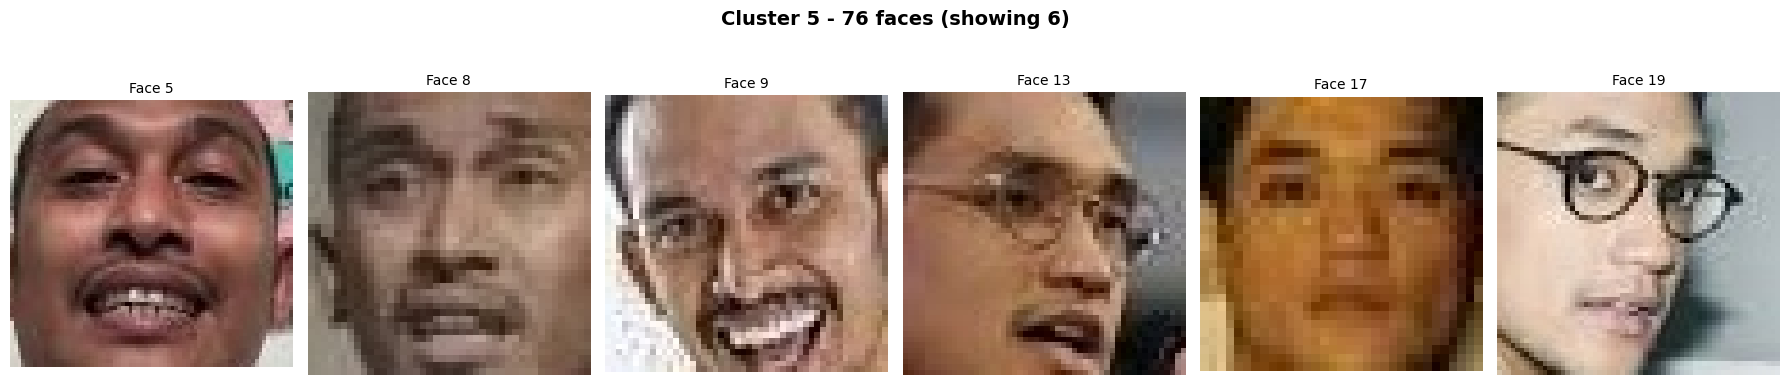

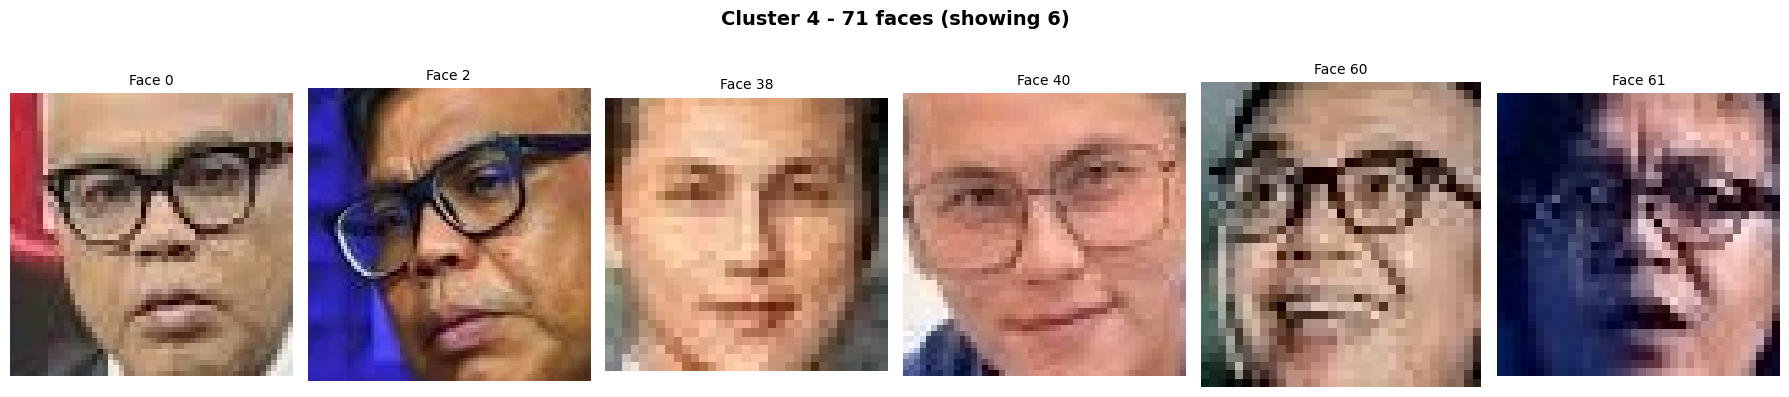

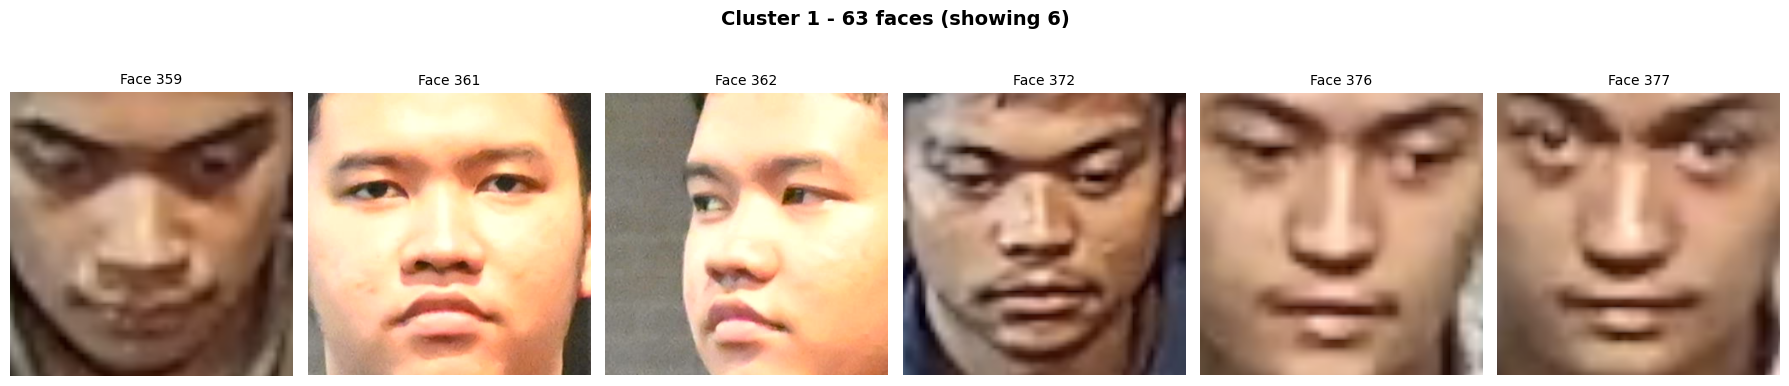

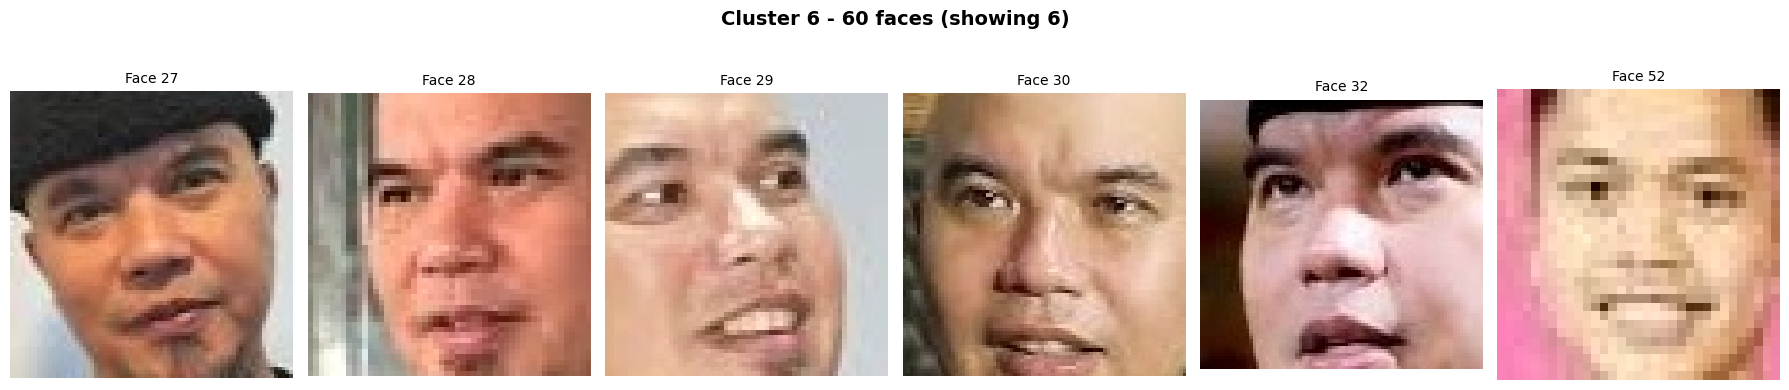

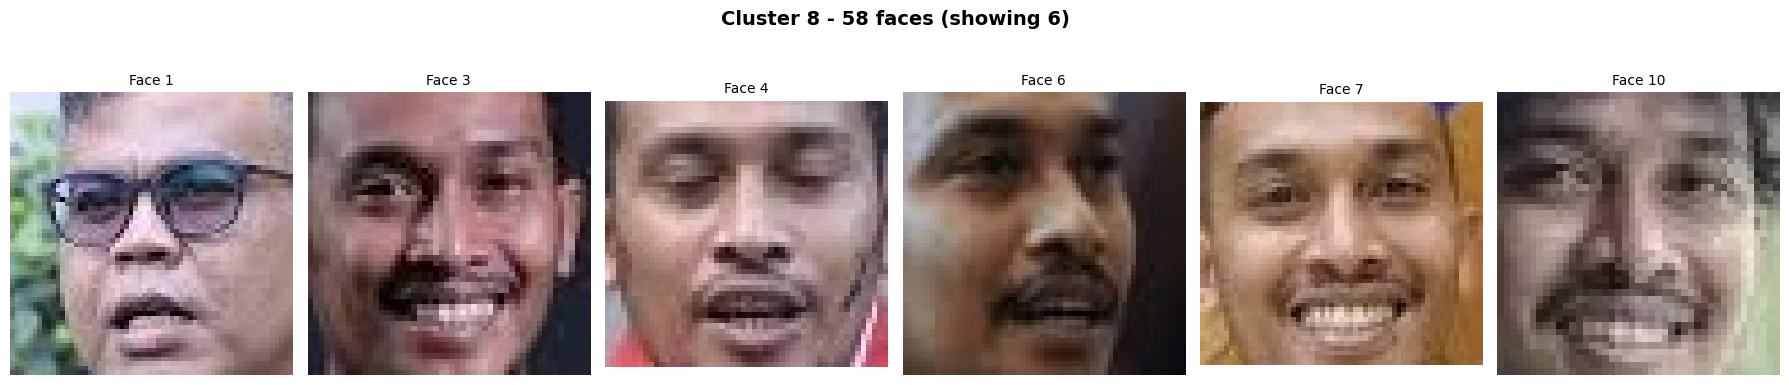

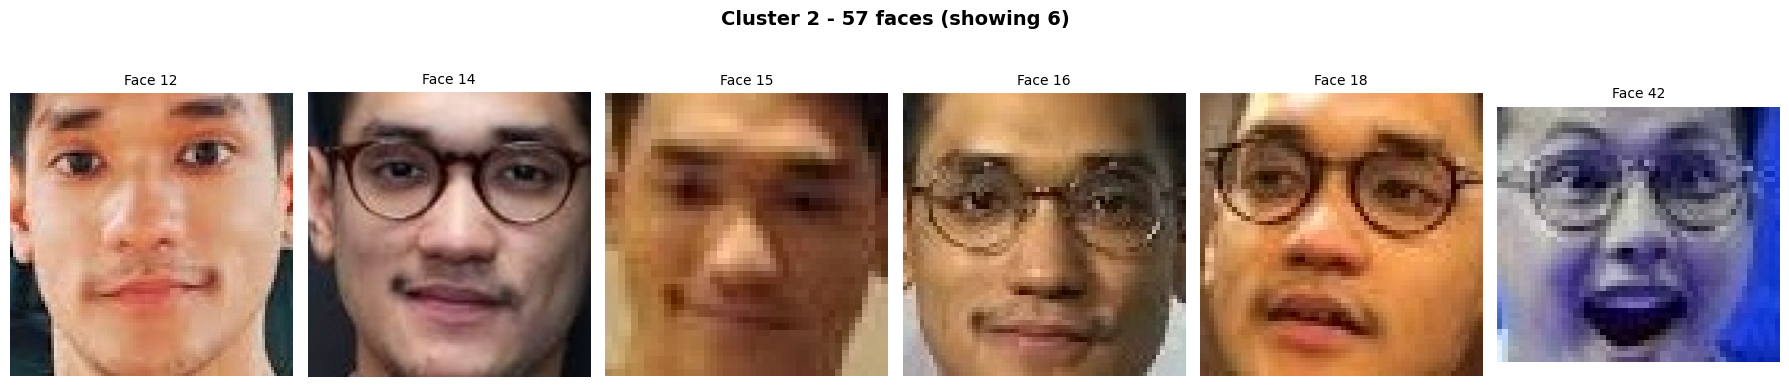

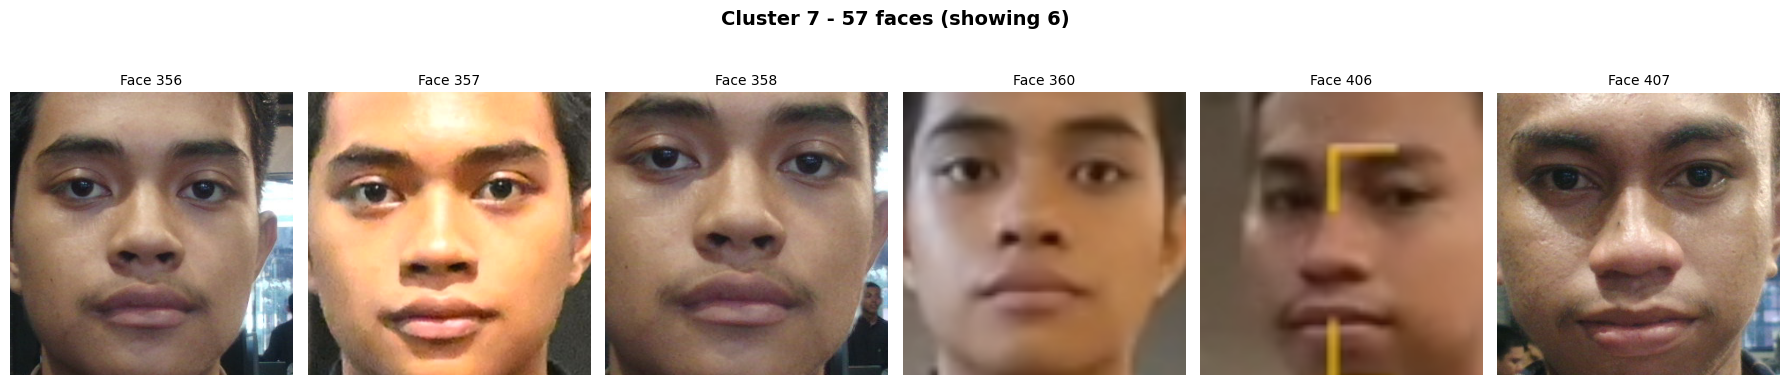

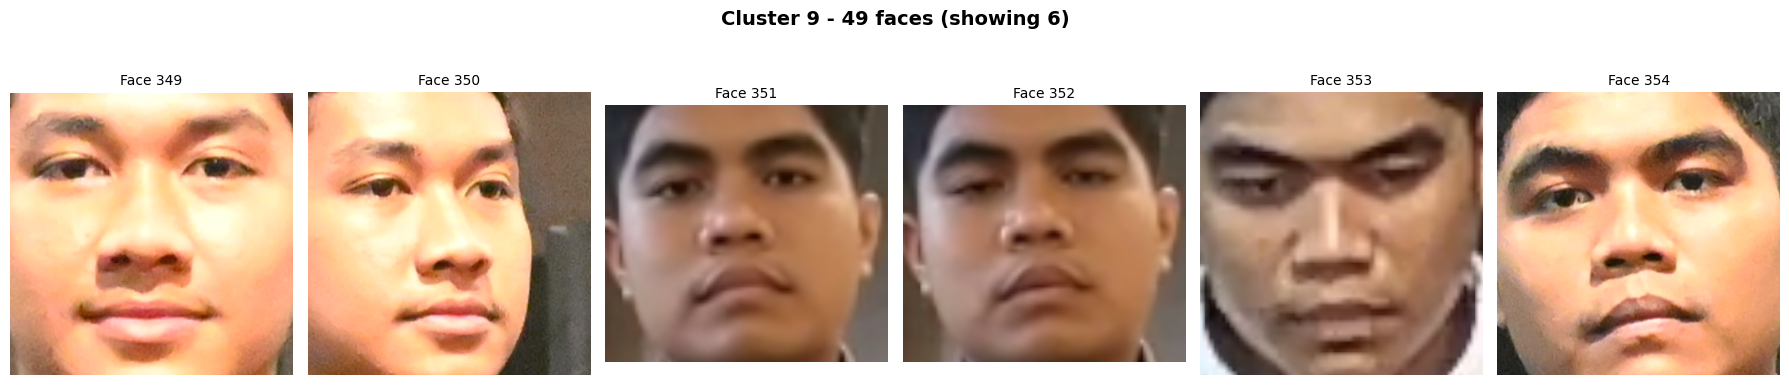

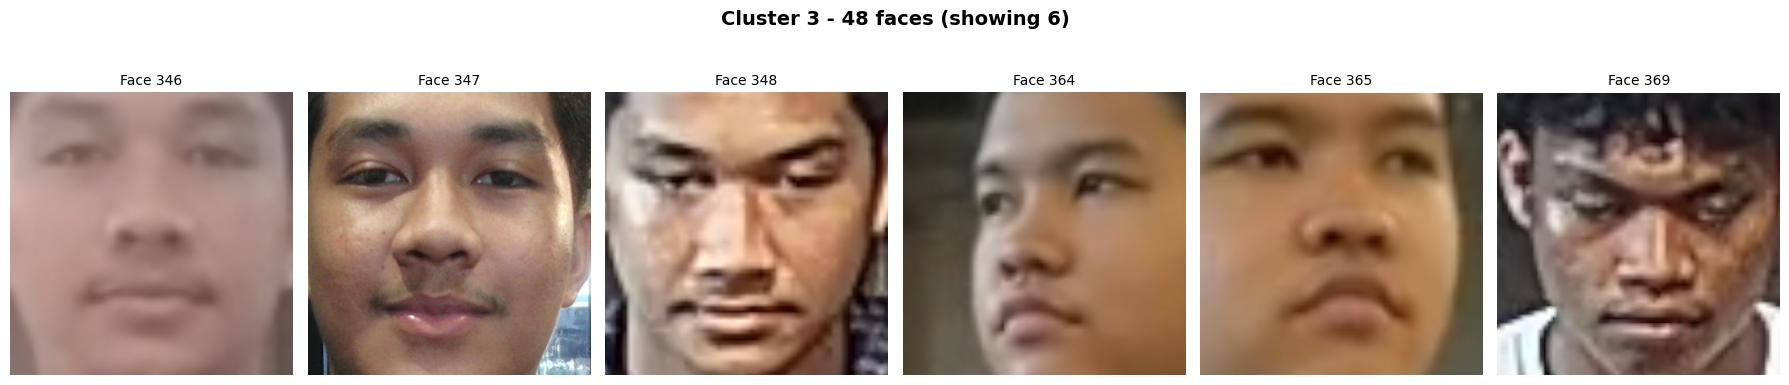

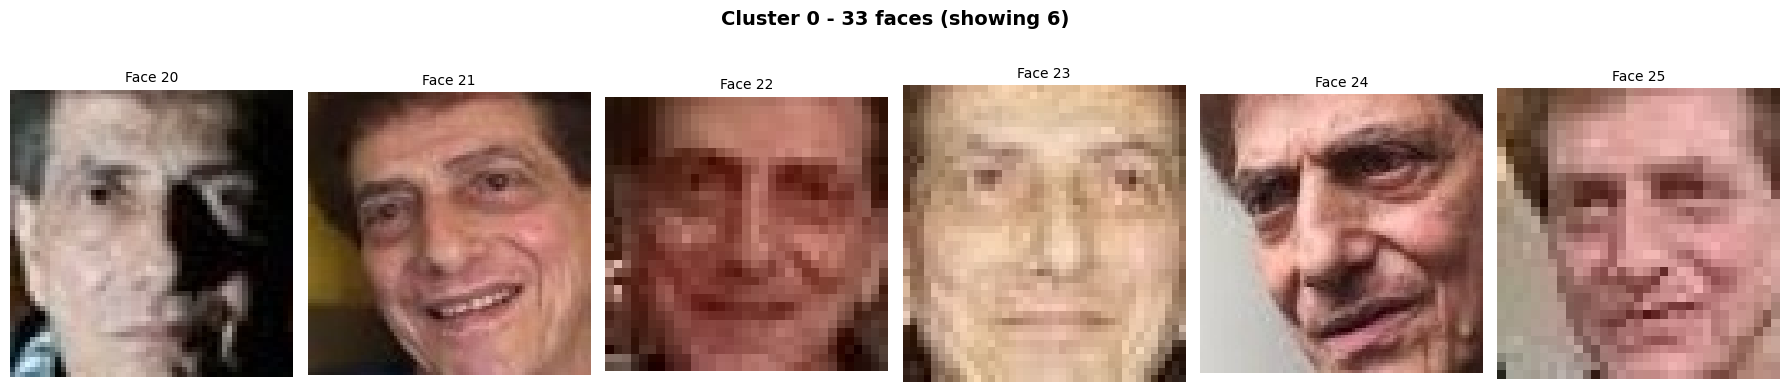


🎉 ANALYSIS COMPLETE!
📈 Total experiments run: 320
🏆 Best silhouette score achieved: 0.8777
🎯 Recommended configuration: DBSCAN with {'eps': 2.0, 'min_samples': 5}


In [53]:
def visualize_clusters_enhanced(image_paths, face_locations, labels, max_clusters=20, max_faces_per_cluster=6):
    """Enhanced cluster visualization with better layout"""
    
    # Get unique labels excluding noise (-1)
    unique_labels = sorted(set(labels))
    if -1 in unique_labels:
        unique_labels.remove(-1)
    
    # Limit the number of clusters to display
    clusters_to_show = min(len(unique_labels), max_clusters)
    
    print(f"\n📸 VISUALIZING TOP {clusters_to_show} CLUSTERS")
    
    # Sort clusters by size (largest first)
    cluster_sizes = [(label, np.sum(labels == label)) for label in unique_labels]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)
    
    for i, (cluster_id, cluster_size) in enumerate(cluster_sizes[:clusters_to_show]):
        # Get indices of faces in this cluster
        cluster_indices = np.where(labels == cluster_id)[0]
        
        # Limit faces per cluster
        faces_to_show = min(len(cluster_indices), max_faces_per_cluster)
        
        plt.figure(figsize=(18, 4))
        plt.suptitle(f'Cluster {cluster_id} - {cluster_size} faces (showing {faces_to_show})', 
                     fontsize=14, fontweight='bold')
        
        for j, idx in enumerate(cluster_indices[:faces_to_show]):
            try:
                # Load image
                img = cv2.imread(image_paths[idx])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Extract face using location
                top, right, bottom, left = face_locations[idx]
                face = img[top:bottom, left:right]
                
                plt.subplot(1, faces_to_show, j+1)
                plt.imshow(face)
                plt.title(f"Face {idx}", fontsize=10)
                plt.axis('off')
            except Exception as e:
                print(f"Error displaying face {idx}: {e}")
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.8)
        plt.show()
    
    # Show noise points if they exist
    if -1 in set(labels):
        noise_indices = np.where(labels == -1)[0]
        noise_to_show = min(len(noise_indices), max_faces_per_cluster)
        
        if noise_to_show > 0:
            plt.figure(figsize=(18, 4))
            plt.suptitle(f'Noise Points - {len(noise_indices)} faces (showing {noise_to_show})', 
                         fontsize=14, fontweight='bold', color='red')
            
            for j, idx in enumerate(noise_indices[:noise_to_show]):
                try:
                    # Load image
                    img = cv2.imread(image_paths[idx])
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Extract face using location
                    top, right, bottom, left = face_locations[idx]
                    face = img[top:bottom, left:right]
                    
                    plt.subplot(1, noise_to_show, j+1)
                    plt.imshow(face)
                    plt.title(f"Noise {idx}", fontsize=10)
                    plt.axis('off')
                except Exception as e:
                    print(f"Error displaying noise face {idx}: {e}")
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.8)
            plt.show()

# Visualize final results
if 'final_labels' in locals() and len(image_paths) > 0:
    visualize_clusters_enhanced(image_paths, all_locations, final_labels)

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"📈 Total experiments run: {len(all_clustering_results)}")
if len(valid_results) > 0:
    print(f"🏆 Best silhouette score achieved: {valid_results['silhouette_score'].iloc[0]:.4f}")
    print(f"🎯 Recommended configuration: {best_result['method']} with {best_result['parameters']}")